In [1]:
import pandas as pd

# Load data
df = pd.read_csv("./IID_Performance.csv", index_col=0)

In [2]:
df

,mIOU (Test),F1 (Test),Acc (Test),loss (Test)
global (Segformer),0.4856,0.6322,0.8325,0.5909
global (Resnet),0.4798,0.6103,0.8238,0.5769
client 0,0.3490,0.4629,0.8044,0.7763
client 1,0.3718,0.5263,0.7969,0.7906
client 2,0.4226,0.5344,0.8065,0.6138
client 3,0.3697,0.4914,0.7937,0.7641
client 4,0.3272,0.4400,0.7984,0.9353
client 5,0.3723,0.5058,0.7860,0.7405
client 6,0.4257,0.5502,0.8106,0.6360
client 7,0.3794,0.4929,0.7949,0.8912


<Axes: >

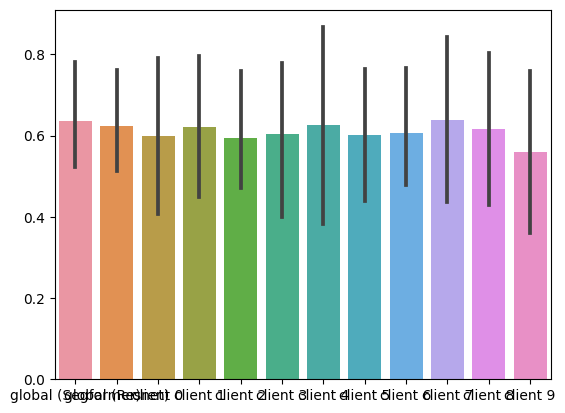

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Seaborn을 사용하여 bar plot을 그립니다.
# sns.barplot(x='index', y='mIOU (Test)', data=df)
sns.barplot(data=df.transpose())
# # 그래프에 제목을 추가합니다.
# plt.title('Bar Plot')

# # 그래프를 표시합니다.
# plt.show()
# # Plot
# sns.set_theme(style="whitegrid")
# sns.set_context("paper", font_scale=1.5)
# fig, ax = plt.subplots(figsize=(10, 5))
# # ax = sns.barplot(x=df.index, y=["mIOU (Test)", "F1 (Test)", "Acc (Test)"], data=df, palette="Blues_d")
# ax = sns.barplot(x=df.index, y=["mIOU (Test)", "F1 (Test)", "Acc (Test)"], data=df, palette="Blues_d")

In [16]:
# 샘플 데이터
data = {
    'clients': ['client1', 'client2', 'client3', 'client4', 'client5', 'client6', 'client7', 'client8', 'client9', 'client10'],
    'mIOU': [0.1, 0.5, 0.7, 0.3, 0.6, 0.8, 0.5, 0.4, 0.6, 0.7],
    'F1': [0.5, 0.6, 0.7, 0.8, 0.5, 0.4, 0.6, 0.7, 0.5, 0.6],
    'ACC': [0.9, 0.8, 0.7, 0.6, 0.7, 0.8, 0.9, 0.7, 0.8, 0.6]
}

# DataFrame으로 변환
df = pd.DataFrame(data)
df

,clients,mIOU,F1,ACC
0,client1,0.1,0.5,0.9
1,client2,0.5,0.6,0.8
2,client3,0.7,0.7,0.7
3,client4,0.3,0.8,0.6
4,client5,0.6,0.5,0.7
5,client6,0.8,0.4,0.8
6,client7,0.5,0.6,0.9
7,client8,0.4,0.7,0.7
8,client9,0.6,0.5,0.8
9,client10,0.7,0.6,0.6


In [19]:
def plot_bargraph(df, save_path, title):
    """
    :param df: DataFrame with columns 'clients', 'mIOU', 'F1', 'Acc'
    """
    # 데이터를 긴 형식으로 변경합니다.
    df_long = pd.melt(df, id_vars=['clients'], value_vars=df.columns[1:])
    
    # 바 그래프 그리기
    plt.figure(figsize=(10, 5))
    sns.barplot(x='clients', y='value', hue='variable', data=df_long)
    
    # x축과 y축 라벨 설정
    # plt.xlabel('Clients')
    plt.ylabel('Scores')
    
    # 그래프 제목 설정
    plt.title(title)
    
    # 범례 추가
    plt.legend(title='Metrics (Test)')
    
    # 그래프 표시
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()


In [20]:
df

,clients,F1,Acc
0,global (Segformer),0.6535,0.8374
1,global (Resnet),0.6061,0.8204
2,client 0,0.4496,0.7851
3,client 1,0.2809,0.7582
4,client 2,0.3531,0.8007
5,client 3,0.3568,0.7481
6,client 4,0.2710,0.7553
7,client 5,0.4380,0.7764
8,client 6,0.3951,0.7740
9,client 7,0.3075,0.7431


Index(['clients', 'F1', 'Acc'], dtype='object')


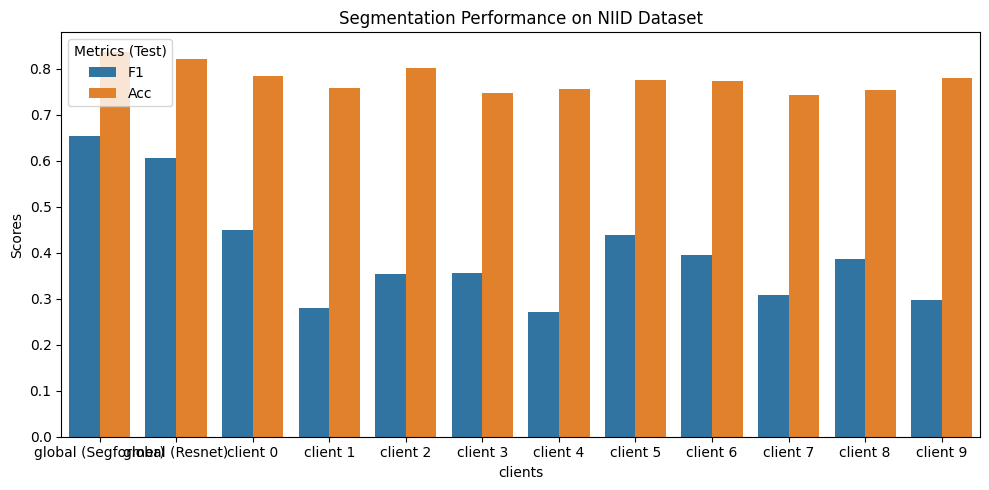

Index(['clients', 'F1', 'Acc'], dtype='object')


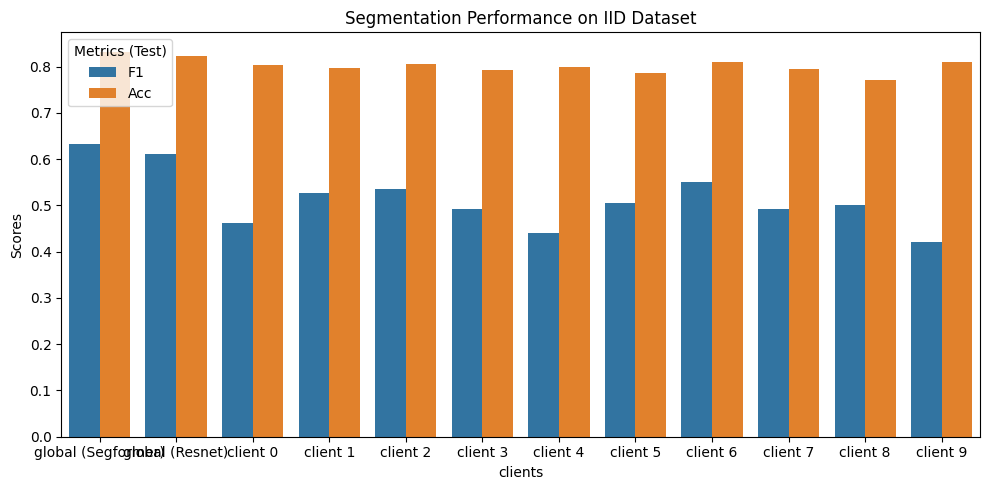

In [21]:
df = pd.read_csv("./NIID_Performance.csv", index_col=0)
df.reset_index(names='clients', inplace=True)
df.columns = df.columns.str.replace(' (Test)','')
df.drop(columns=['mIOU', 'loss'], inplace=True)
print(df.columns)
plot_bargraph(df, './NIID_Performance.png', 'Segmentation Performance on NIID Dataset')
df = pd.read_csv("./IID_Performance.csv", index_col=0)
df.reset_index(names='clients', inplace=True)
df.columns = df.columns.str.replace(' (Test)','')
df.drop(columns=['mIOU', 'loss'], inplace=True)
print(df.columns)
plot_bargraph(df, './IID_Performance.png', 'Segmentation Performance on IID Dataset')

In [23]:
# 1. 각각의 Client로컬 학습 모델의 Receptive Field를 계산한다.
# 

import os
import sys
import pathlib
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import torch
import models
import utils

def load_all_models(path):
    folder_path = path
    file_list = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".pth"):
                file_list.append(pathlib.Path(root) / file)
    # sorting file_list
    file_list.sort()
    # dirnames
    model_state_dict = {}
    for file in file_list:
        print("file_name : ", file)
        # get index from file name ex. "client_0_best_models" > "0", "test 1" > "1"
        if 'global' in file.parent.name:
            model_state_dict[-1] = torch.load(file) 
            print("file.parent.name: ", file.parent.name)
        else:
            index = int(file.parent.name.split('_')[1])
            model_state_dict[index] = torch.load(file)
            print("file.parent.name: ", file.parent.name, "index: ", index)
    return model_state_dict

model_state_dict = load_all_models("/home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/_56121")# 55227")
model_state_dict[-1] = torch.load("/home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/38125/global/model_round99_acc82.04_loss0.64.pth")
model_state_dict[-2] = torch.load("/home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/42301/global/model_round99_acc83.74_loss0.58.pth")

file_name :  /home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/_56121/client_0_best_models/model_round49_acc79.41_loss0.90.pth
file.parent.name:  client_0_best_models index:  0
file_name :  /home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/_56121/client_1_best_models/model_round86_acc90.98_loss0.27.pth
file.parent.name:  client_1_best_models index:  1
file_name :  /home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/_56121/client_2_best_models/model_round30_acc94.40_loss0.22.pth
file.parent.name:  client_2_best_models index:  2
file_name :  /home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/_56121/client_3_best_models/model_round53_acc90.52_loss0.28.pth
file.parent.name:  client_3_best_models index:  3
file_name :  /home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/_56121/client_4_best_models/model_round60_acc95.83_loss0.24.pth
file.parent.name:  client_4_best_models index:  4
file_name :  /home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/_56121/client_5_best_models/

In [49]:
import datasets
import config
from torch.utils.data import DataLoader

args = config.init_args(server=False, ipykernel=True)
args.output_size = 224
datasetpartition = datasets.PascalVocSegmentationPartition(args)
train_dataset, valid_dataset = datasetpartition.load_partition(-1)
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=0 )
valid_loader = DataLoader(valid_dataset, batch_size=args.batch_size, shuffle=False, num_workers=0 )
test_loader = valid_loader


args.excluded_heads []
malicious clients: []
dirichlet
1464 1449


Loading pretrained model...


<All keys matched successfully>

In [51]:
args.device = torch.device("cuda:0" if torch.cuda.is_available() and args.use_cuda else "cpu")

In [91]:
import torchmetrics
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import segmentation_models_pytorch as smp
import numpy as np
from poutyne import Model

def test(net, testloader, steps: int = None, device: str = "cpu", args=None):
    net = net.to(device)
    
    last_layer_name = list(net.named_children())[-1][0]
    parameters = [
        {'params': [p for n, p in net.named_parameters() if last_layer_name not in n], 'lr': args.learning_rate},
        {'params': [p for n, p in net.named_parameters() if last_layer_name in n], 'lr': args.learning_rate*args.multifly_lr_lastlayer},
    ]
    optimizer = optim.Adam(parameters, lr=args.learning_rate)

    if args.loss_fn == "cross_entropy":
        criterion = nn.CrossEntropyLoss()
    elif args.loss_fn == "dice_loss":
        criterion = smp.losses.DiceLoss(mode = 'multiclass')
    elif args.loss_fn == "focal_loss":
        criterion = smp.losses.FocalLoss(mode = 'multiclass')
    elif args.loss_fn == "LovaszLoss":
        criterion = smp.losses.LovaszLoss(mode = 'multiclass')
    
    from torchmetrics import Accuracy

    def calculate_pixel_accuracy(predictions, targets):
        predictions = predictions.cpu().detach().numpy()
        targets = targets.cpu().detach().numpy()
        """
        Calculates the Pixel Accuracy for Segmentation.
        
        Args:
            predictions (tensor): Predicted segmentation masks.
            targets (tensor): Ground truth segmentation masks.
        
        Returns:
            pixel_accuracy (tensor): Pixel Accuracy for Segmentation.
        """
        accuracy = Accuracy(num_classes=21, task="multiclass")
        pixel_accuracy = accuracy(predictions, targets)
        return pixel_accuracy

    model = Model(
        net,
        optimizer,
        criterion,
        batch_metrics=['accuracy'],
        epoch_metrics=['f1', torchmetrics.JaccardIndex(num_classes=args.num_classes, task="multiclass"),
                       'precision', 'recall'],
        device=device,
    )
    
    logs = model.evaluate_generator(testloader, return_dict_format=True) #, steps=steps)
    
    return logs

input: torch.Size([16, 21, 224, 224]), target: torch.Size([16, 224, 224])
Step:  1/91   1.10% |▏                   |ETA: 10m58.53s test_loss: 0.585242 test_acc: 85.344955input: torch.Size([16, 21, 224, 224]), target: torch.Size([16, 224, 224])
Step:  2/91   2.20% |▍                   |ETA: 8m42.50s test_loss: 1.025530 test_acc: 71.592491 input: torch.Size([16, 21, 224, 224]), target: torch.Size([16, 224, 224])
Step:  3/91   3.30% |▋                   |ETA: 4m26.14s test_loss: 0.513438 test_acc: 82.881752input: torch.Size([16, 21, 224, 224]), target: torch.Size([16, 224, 224])
Step:  4/91   4.40% |▉                   |ETA: 2m43.72s test_loss: 0.786359 test_acc: 83.243858input: torch.Size([16, 21, 224, 224]), target: torch.Size([16, 224, 224])
Step:  5/91   5.49% |█                   |ETA: 1m54.11s test_loss: 0.454790 test_acc: 84.670212input: torch.Size([16, 21, 224, 224]), target: torch.Size([16, 224, 224])
Step:  6/91   6.59% |█▎                  |ETA: 4m12.15s test_loss: 1.000356 tes

In [101]:
total_logs = {}
args.loss_fn = "cross_entropy"
deeplabv3plus = models.get_network("deeplabv3plus", args.num_classes, args.pretrained, args.excluded_heads)
deeplabv3plus.load_state_dict(model_state_dict[-1])
total_logs[-1] = test(deeplabv3plus, test_loader, device=args.device, args=args)

In [ ]:
args.output_size = 56
datasetpartition = datasets.PascalVocSegmentationPartition(args)
train_dataset, valid_dataset = datasetpartition.load_partition(-1)
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=0 )
valid_loader = DataLoader(valid_dataset, batch_size=args.batch_size, shuffle=False, num_workers=0 )
test_loader = valid_loader

segformer = models.get_network("segformer", args.num_classes, args.pretrained, args.excluded_heads)
from tqdm import tqdm
for index in tqdm([-2, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]):
    segformer.load_state_dict(model_state_dict[index])
    total_logs[index] = test(segformer, test_loader, device=args.device, args=args)

In [128]:
total_logs_df = pd.DataFrame(total_logs)
total_logs_df = total_logs_df.transpose()
total_logs_df.reset_index(names='clients', inplace=True)
replace_dict={'-1': 'global (segformer)', '-2': 'global (deeplabv3plus)', '0': 'client 0', '1': 'client 1', '2': 'client 2', '3': 'client 3', '4': 'client 4', '5': 'client 5', '6': 'client 6', '7': 'client 7', '8': 'client 8', '9': 'client 9'}
replace_dict = {int(k): v for k, v in replace_dict.items()}
total_logs_df['clients'] = total_logs_df.clients.apply(lambda x: replace_dict[x])
rename_columns = {'test_loss':'loss', 'test_acc':'acc', 'test_fscore_macro':'f1', 'test_multiclass_jaccard_index':'mIOU', 'test_precision_macro':'precision', 'test_recall_macro':'recall'}
total_logs_df.rename(columns=rename_columns, inplace=True)
total_logs_df.to_csv("./total_logs_NIID.csv", index=False)


In [105]:
import pandas as pd
total_logs_df = pd.DataFrame(total_logs)
# -2 : global (segformerb0)
# -1 : global (resnet34)
# 0~10 : local clients  

total_logs_df.to_csv("./total_logs_NIID.csv")

In [129]:
model_state_dict = load_all_models("/home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/_57584")# 55227")
model_state_dict[-1] = torch.load("/home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/17751/global/model_round89_acc82.38_loss0.59.pth")
model_state_dict[-2] = torch.load("/home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/52840/global/model_round78_acc83.25_loss0.62.pth")

file_name :  /home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/_57584/client_0_best_models/model_round65_acc86.07_loss0.37.pth
file.parent.name:  client_0_best_models index:  0
file_name :  /home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/_57584/client_1_best_models/model_round69_acc94.05_loss0.15.pth
file.parent.name:  client_1_best_models index:  1
file_name :  /home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/_57584/client_2_best_models/model_round27_acc86.22_loss0.67.pth
file.parent.name:  client_2_best_models index:  2
file_name :  /home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/_57584/client_3_best_models/model_round83_acc92.45_loss0.71.pth
file.parent.name:  client_3_best_models index:  3
file_name :  /home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/_57584/client_4_best_models/model_round54_acc90.76_loss0.36.pth
file.parent.name:  client_4_best_models index:  4
file_name :  /home/suncheol/code/FedTest/0_FedMHAD_Seg/checkpoints/_57584/client_5_best_models/

In [ ]:
args.output_size = 224
datasetpartition = datasets.PascalVocSegmentationPartition(args)
train_dataset, valid_dataset = datasetpartition.load_partition(-1)
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=0 )
valid_loader = DataLoader(valid_dataset, batch_size=args.batch_size, shuffle=False, num_workers=0 )
test_loader = valid_loader

total_logs = {}
args.loss_fn = "cross_entropy"
deeplabv3plus = models.get_network("deeplabv3plus", args.num_classes, args.pretrained, args.excluded_heads)
deeplabv3plus.load_state_dict(model_state_dict[-1])
total_logs[-1] = test(deeplabv3plus, test_loader, device=args.device, args=args)

args.output_size = 56
datasetpartition = datasets.PascalVocSegmentationPartition(args)
train_dataset, valid_dataset = datasetpartition.load_partition(-1)
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=0 )
valid_loader = DataLoader(valid_dataset, batch_size=args.batch_size, shuffle=False, num_workers=0 )
test_loader = valid_loader

segformer = models.get_network("segformer", args.num_classes, args.pretrained, args.excluded_heads)
from tqdm import tqdm
for index in tqdm([-2, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]):
    segformer.load_state_dict(model_state_dict[index])
    total_logs[index] = test(segformer, test_loader, device=args.device, args=args)
    
total_logs_df = pd.DataFrame(total_logs)
total_logs_df = total_logs_df.transpose()
total_logs_df.reset_index(names='clients', inplace=True)
replace_dict={'-1': 'global (segformer)', '-2': 'global (deeplabv3plus)', '0': 'client 0', '1': 'client 1', '2': 'client 2', '3': 'client 3', '4': 'client 4', '5': 'client 5', '6': 'client 6', '7': 'client 7', '8': 'client 8', '9': 'client 9'}
replace_dict = {int(k): v for k, v in replace_dict.items()}
total_logs_df['clients'] = total_logs_df.clients.apply(lambda x: replace_dict[x])
rename_columns = {'test_loss':'loss', 'test_acc':'acc', 'test_fscore_macro':'f1', 'test_multiclass_jaccard_index':'mIOU', 'test_precision_macro':'precision', 'test_recall_macro':'recall'}
total_logs_df.rename(columns=rename_columns, inplace=True)
total_logs_df.to_csv("./total_logs_IID.csv", index=False)


In [37]:
import pandas as pd

def plot_bargraph(df, save_path, title):
    """
    :param df: DataFrame with columns 'clients', 'mIOU', 'F1', 'Acc'
    """
    # 데이터를 긴 형식으로 변경합니다.
    df_long = pd.melt(df, id_vars=['clients'], value_vars=df.columns[1:])
    sns.color_palette("Set2")
    # 바 그래프 그리기
    plt.figure(figsize=(10, 7))
    ax = sns.barplot(x='clients', y='value', hue='variable', data=df_long, palette="deep")
    # with labels 
    for p in ax.patches:
        ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
            textcoords='offset points')
    
    # draw text percentile of FL-Segformer vs FL-Deeplabv3+(Rn34) performance
    
    plt.grid(axis='y', linestyle='-', alpha=0.7)
    
    # x축과 y축 라벨 설정
    # plt.xlabel('Clients')
    
      
    plt.ylabel('Scores', fontsize=15)
    plt.xticks(rotation=20, ha='right', fontsize=12)
    
    # draw grid lines
    plt.grid(axis='y', linestyle='-', alpha=0.4)
    # 그래프 제목 설정
    plt.title(title, fontsize=18)
    
    # 범례 추가
    plt.legend(title='Metrics (Test)', loc='lower right', fontsize=15, title_fontsize=15)
    # 그래프 표시
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()


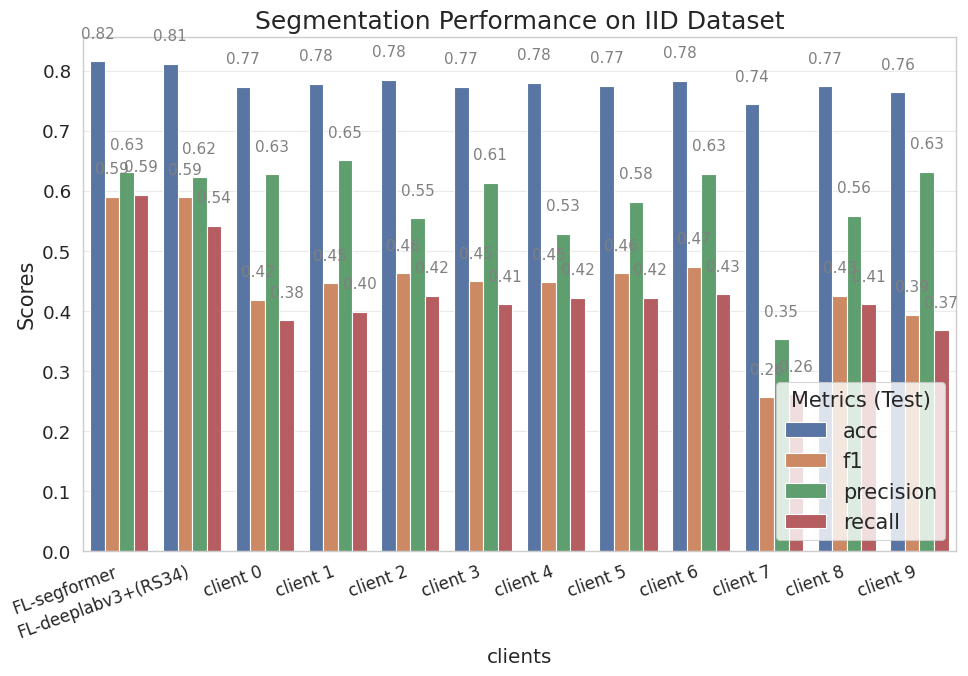

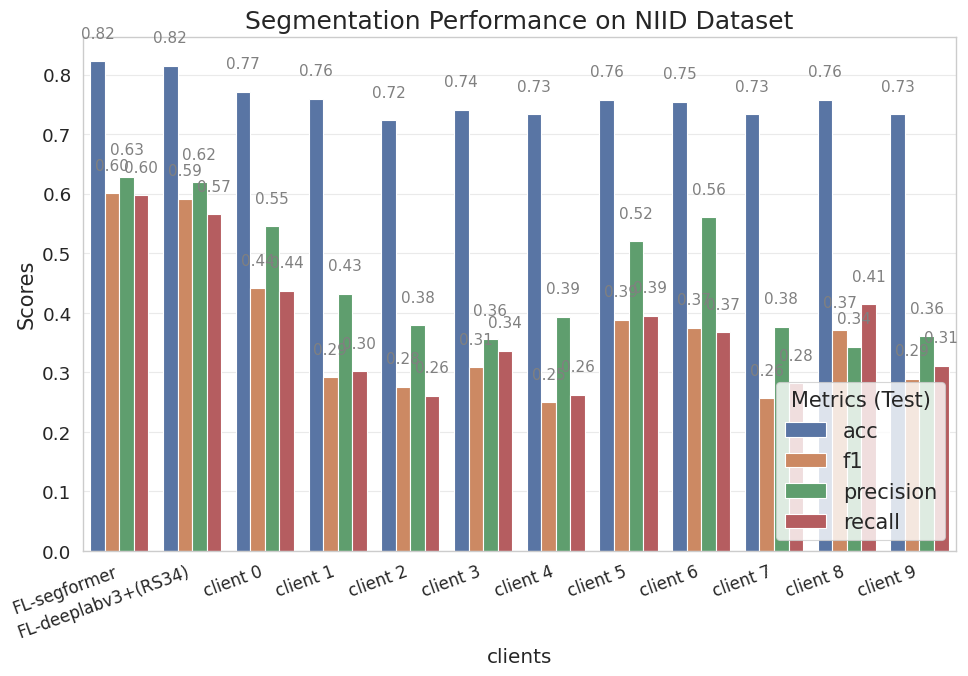

In [38]:
total_logs_df = pd.read_csv("./total_logs_IID.csv")
total_logs_df.acc = total_logs_df.acc / 100
total_logs_df = total_logs_df[['clients', 'acc', 'f1', 'precision', 'recall']]
plot_bargraph(total_logs_df, './total_logs_IID.png', 'Segmentation Performance on IID Dataset')
 
total_logs_df = pd.read_csv("./total_logs_NIID.csv")
total_logs_df.acc = total_logs_df.acc / 100
total_logs_df = total_logs_df[['clients', 'acc', 'f1', 'precision', 'recall']]
plot_bargraph(total_logs_df, './total_logs_NIID.png', 'Segmentation Performance on NIID Dataset')